 Backtest Comparison and Evaluation

In this analysis, we performed three different backtests on a stock trading strategy over the same period in **VN-30 index**. The backtests are as follows:

1. **LSTM-based Strategy**
2. **Rule-Based Strategy** (utilizing MACD, Bollinger Bands, and RSI)
3. **Buy and Hold Strategy**

Let's compare and evaluate these backtests to understand their performance.




In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Preprocessing

In [ ]:
#Get data
df = pd.read_csv("/content/gdrive/MyDrive/Dữ liệu Lịch sử VN 30.csv")
df.head(10)

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,20/10/2023,"1,123.69","1,104.83","1,125.63","1,094.78",154.96K,1.70%
1,19/10/2023,"1,104.89","1,126.67","1,126.86","1,104.89",166.99K,-1.84%
2,18/10/2023,"1,125.56","1,143.95","1,144.89","1,108.68",233.69K,-1.36%
3,17/10/2023,"1,141.03","1,157.63","1,160.30","1,141.03",141.76K,-1.06%
4,16/10/2023,"1,153.21","1,165.75","1,168.02","1,151.13",173.24K,-1.15%
5,13/10/2023,"1,166.66","1,158.34","1,167.61","1,152.58",149.21K,0.10%
6,12/10/2023,"1,165.49","1,167.62","1,172.14","1,162.00",142.88K,-0.15%
7,11/10/2023,"1,167.29","1,161.87","1,167.29","1,154.45",113.75K,0.60%
8,10/10/2023,"1,160.28","1,153.05","1,163.47","1,153.05",155.50K,0.86%
9,09/10/2023,"1,150.37","1,139.07","1,150.37","1,135.67",146.63K,0.93%


In [ ]:
#Get column and row
df.shape

(3693, 7)

In [ ]:
#Change with"K" value to float
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

df['KL'] = df['KL'].apply(value_to_float)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,20/10/2023,"1,123.69","1,104.83","1,125.63","1,094.78",154960.0,1.70%
1,19/10/2023,"1,104.89","1,126.67","1,126.86","1,104.89",166990.0,-1.84%
2,18/10/2023,"1,125.56","1,143.95","1,144.89","1,108.68",233690.0,-1.36%
3,17/10/2023,"1,141.03","1,157.63","1,160.30","1,141.03",141760.0,-1.06%
4,16/10/2023,"1,153.21","1,165.75","1,168.02","1,151.13",173240.0,-1.15%
...,...,...,...,...,...,...,...
3688,09/01/2009,312.90,312.90,312.90,312.90,NaN,-0.39%
3689,08/01/2009,314.14,314.14,314.14,314.14,NaN,-1.99%
3690,07/01/2009,320.53,320.53,320.53,320.53,NaN,2.01%
3691,06/01/2009,314.21,314.21,314.21,314.21,NaN,0.96%


In [ ]:
#Rename columns
df.columns = ['Date', 'Close', 'Open', 'High','Low','Volume','Change']
df

,Date,Close,Open,High,Low,Volume,Change
0,20/10/2023,"1,123.69","1,104.83","1,125.63","1,094.78",154960.0,1.70%
1,19/10/2023,"1,104.89","1,126.67","1,126.86","1,104.89",166990.0,-1.84%
2,18/10/2023,"1,125.56","1,143.95","1,144.89","1,108.68",233690.0,-1.36%
3,17/10/2023,"1,141.03","1,157.63","1,160.30","1,141.03",141760.0,-1.06%
4,16/10/2023,"1,153.21","1,165.75","1,168.02","1,151.13",173240.0,-1.15%
...,...,...,...,...,...,...,...
3688,09/01/2009,312.90,312.90,312.90,312.90,NaN,-0.39%
3689,08/01/2009,314.14,314.14,314.14,314.14,NaN,-1.99%
3690,07/01/2009,320.53,320.53,320.53,320.53,NaN,2.01%
3691,06/01/2009,314.21,314.21,314.21,314.21,NaN,0.96%


In [ ]:
df = df.replace(',','', regex=True)
df

,Date,Close,Open,High,Low,Volume,Change
0,20/10/2023,1123.69,1104.83,1125.63,1094.78,154960.0,1.70%
1,19/10/2023,1104.89,1126.67,1126.86,1104.89,166990.0,-1.84%
2,18/10/2023,1125.56,1143.95,1144.89,1108.68,233690.0,-1.36%
3,17/10/2023,1141.03,1157.63,1160.30,1141.03,141760.0,-1.06%
4,16/10/2023,1153.21,1165.75,1168.02,1151.13,173240.0,-1.15%
...,...,...,...,...,...,...,...
3688,09/01/2009,312.90,312.90,312.90,312.90,NaN,-0.39%
3689,08/01/2009,314.14,314.14,314.14,314.14,NaN,-1.99%
3690,07/01/2009,320.53,320.53,320.53,320.53,NaN,2.01%
3691,06/01/2009,314.21,314.21,314.21,314.21,NaN,0.96%


In [ ]:
#Check null value
df.isnull().sum()
df.fillna(0)


,Date,Close,Open,High,Low,Volume,Change
0,20/10/2023,1123.69,1104.83,1125.63,1094.78,154960.0,1.70%
1,19/10/2023,1104.89,1126.67,1126.86,1104.89,166990.0,-1.84%
2,18/10/2023,1125.56,1143.95,1144.89,1108.68,233690.0,-1.36%
3,17/10/2023,1141.03,1157.63,1160.30,1141.03,141760.0,-1.06%
4,16/10/2023,1153.21,1165.75,1168.02,1151.13,173240.0,-1.15%
...,...,...,...,...,...,...,...
3688,09/01/2009,312.90,312.90,312.90,312.90,0.0,-0.39%
3689,08/01/2009,314.14,314.14,314.14,314.14,0.0,-1.99%
3690,07/01/2009,320.53,320.53,320.53,320.53,0.0,2.01%
3691,06/01/2009,314.21,314.21,314.21,314.21,0.0,0.96%


In [ ]:
df.dtypes

Date       object
Close      object
Open       object
High       object
Low        object
Volume    float64
Change     object
dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Close'] = df['Close'].astype('float')
df['Open'] = df['Open'].astype('float')
df['High'] = df['High'].astype('float')
df['Low'] = df['Low'].astype('float')
df.dtypes

Date      datetime64[ns]
Close            float64
Open             float64
High             float64
Low              float64
Volume           float64
Change            object
dtype: object

In [ ]:
df

,Date,Close,Open,High,Low,Volume,Change
0,2023-10-20,1123.69,1104.83,1125.63,1094.78,154960.0,1.70%
1,2023-10-19,1104.89,1126.67,1126.86,1104.89,166990.0,-1.84%
2,2023-10-18,1125.56,1143.95,1144.89,1108.68,233690.0,-1.36%
3,2023-10-17,1141.03,1157.63,1160.30,1141.03,141760.0,-1.06%
4,2023-10-16,1153.21,1165.75,1168.02,1151.13,173240.0,-1.15%
...,...,...,...,...,...,...,...
3688,2009-01-09,312.90,312.90,312.90,312.90,NaN,-0.39%
3689,2009-01-08,314.14,314.14,314.14,314.14,NaN,-1.99%
3690,2009-01-07,320.53,320.53,320.53,320.53,NaN,2.01%
3691,2009-01-06,314.21,314.21,314.21,314.21,NaN,0.96%


In [ ]:
df_new = df.copy()

In [ ]:
df_new_1 = df.copy()

In [ ]:
df = df.sort_values(by='Date')

In [ ]:
df = df.set_index('Date')

In [ ]:
df = df.drop(columns=['Change'])

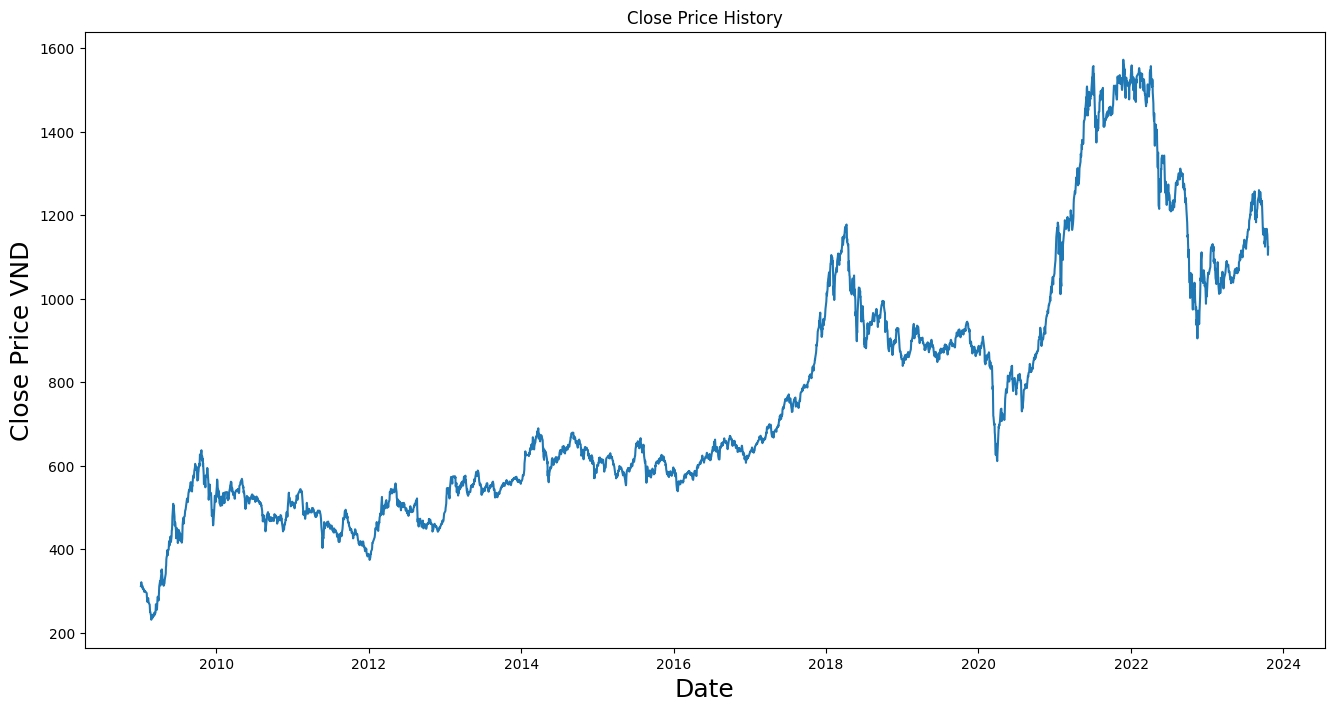

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price VND', fontsize = 18)
plt.show()



# Why Choose LSTM for Predicting Stock Prices?
 LSTM is a compelling choice for predicting stock prices due to its ability to model sequential data, handle long-term dependencies, and capture complex patterns. Moreover, LSTMs are a type of RNN that remember information over long periods of time, making them better suited for predicting stock prices.

## Analyzing Time Series Stationarity with the Augmented Dickey-Fuller Test

In this cell codes, we are performing a stationarity test on a time series using the Augmented Dickey-Fuller test. The test checks whether a time series is stationary, which is a crucial assumption for many time series analysis techniques.


1. **Define the ADF Test Function:** You define a function named `adf_test` that takes a `timeseries` as its input. This function conducts the Augmented Dickey-Fuller test on the given time series.
2. **ADF Test and Output:** Within the `adf_test` function:
   - You print the title "Results of Dickey-Fuller Test" to indicate the test's purpose.
   - You use `adfuller` from `statsmodels` to perform the test, specifying the `autolag` parameter as 'AIC' to automatically determine the optimal lag order.
   - The test results are stored in the variable `dftest`, which contains the test statistic, p-value, number of lags used, and the number of observations used.
   - You create a Pandas Series called `dfoutput` to organize and label the test results, including the test statistic, p-value, number of lags used, and number of observations used.
   - Next, you add the critical values to the `dfoutput` Series. The critical values are used to determine the significance of the test results.
   - Finally, you print the `dfoutput`, which provides a comprehensive summary of the Augmented Dickey-Fuller test results.



3. **Logarithmic Transformation:** You then transform the 'Close' column of your data frame by taking the natural logarithm (log). This transformation is a common method to stabilize variance and make time series data more stationary for further analysis.



The Augmented Dickey-Fuller test results and the stationary time series are essential steps in preparing time series data for further analysis, such as forecasting or modeling.


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
  # Create a Series to store and label the test results

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   # Add the critical values to the output Series

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#Applied fuction
adf_test(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.475765
p-value                           0.545464
#Lags Used                       22.000000
Number of Observations Used    3670.000000
Critical Value (1%)              -3.432133
Critical Value (5%)              -2.862328
Critical Value (10%)             -2.567189
dtype: float64


Based on the Dickey-Fuller test results you've provided,  the data is **non-stationary.**

Because the test statistic is less negative than the critical values at the 1%, 5%, and 10% significance levels, and the p-value is relatively high (greater than 0.05)

In [ ]:
# Transforming a DataFrame Column by Taking the Natural Logarithm
df['stationary_Close'] = np.log(df['Close'])
df['stationary_Close']

Date
2009-01-05    5.740532
2009-01-06    5.750062
2009-01-07    5.769976
2009-01-08    5.749839
2009-01-09    5.745884
                ...   
2023-10-16    7.050305
2023-10-17    7.039687
2023-10-18    7.026036
2023-10-19    7.007501
2023-10-20    7.024373
Name: stationary_Close, Length: 3693, dtype: float64

## Creating Training Data Subset for an LSTM Model

1. **Slice the Dataset:** The code begins by taking a portion of the dataset to use for training. This portion is referred to as the "training data subset."

2. **Defining Time Steps (Days):** The variable `n` is set to 30. This means that we're working with a time series data where each data point represents one day. So, `n = 30` means we're looking at the past 30 days of data to make predictions.

3. **Loop to Create Input-Output Pairs:**

   - A loop is used to go through the training data.

   - For each iteration of the loop (starting from day 30 and moving forward), we're creating input-output pairs for a machine learning model.

   - **Input Sequences (`x_train`):** For input data, we take the data from the past 30 days (as determined by the value of `n`). These 30 days' worth of data are stored as an input sequence.

   - **Target Values (`y_train`):** The target value, or what we want the model to predict, is the data point for the current day. This is stored as the output value.

4. **Printing the Pairs:** For the first 32 iterations of the loop, the code prints the input sequences (`x_train`) and their corresponding target values (`y_train`) to help us understand how the data is being prepared for training the model.

In simple terms, this code takes a chunk of data, focuses on a 30-day window, and creates pairs of 30-day historical data as input and the data for the next day as the output. This is done to train a machine learning model, like an LSTM (Long Short-Term Memory), for time series forecasting or prediction.


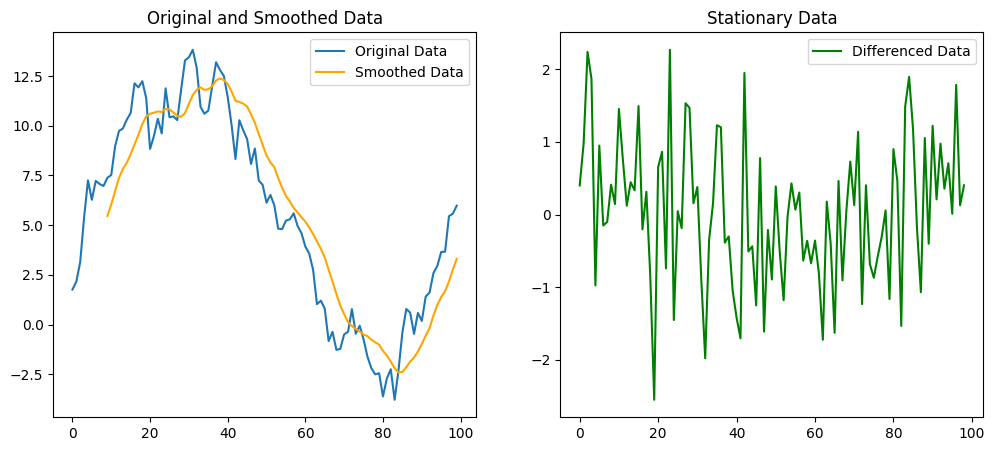

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create sample time series data
np.random.seed(0)
data = np.random.normal(0, 1, 100).cumsum()

# Smoothing with Moving Average
window_size = 10
moving_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Making the data stationary with differencing
differenced = np.diff(data)

# Plotting
plt.figure(figsize=(12, 5))

# Original and Smoothed Data
plt.subplot(1, 2, 1)
plt.plot(data, label='Original Data')
plt.plot(np.arange(window_size - 1, 100), moving_avg, label='Smoothed Data', color='orange')
plt.title('Original and Smoothed Data')
plt.legend()

# Differenced Data
plt.subplot(1, 2, 2)
plt.plot(differenced, label='Differenced Data', color='green')
plt.title('Stationary Data')
plt.legend()

plt.show()


In [ ]:
#Create a new dataframe with only the "Close" column
data = df.filter(['stationary_Close'])
#Covert the dataframe to array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2955

In [ ]:
# Slice the dataset to create your training data subset.
train_data = dataset[0:training_data_len, :]

x_train = []
y_train = []
# Define the number of time steps (days)
n = 30
# Loop through the training data to create input-output pairs for the LSTM model.
for i in range(n,len(train_data)) :
   # Create input sequences by taking the last 'n' time steps.
  x_train.append(train_data[i-n:i])
  # Create target values, which are the data point at the current time step.
  y_train.append(train_data[i])
   # Print
  if i <= 31 :
    print(x_train)
    print(y_train)
    print()

[array([[5.74053219],
       [5.75006155],
       [5.76997588],
       [5.74983875],
       [5.74588365],
       [5.74370807],
       [5.72603308],
       [5.73100846],
       [5.71554634],
       [5.72116387],
       [5.71745524],
       [5.7092011 ],
       [5.69558228],
       [5.69873643],
       [5.7053812 ],
       [5.68480351],
       [5.64848116],
       [5.63991928],
       [5.61141131],
       [5.62596507],
       [5.64431552],
       [5.62524419],
       [5.60333579],
       [5.6019343 ],
       [5.59638284],
       [5.58833421],
       [5.55183492],
       [5.51905803],
       [5.51997982],
       [5.50975264]])]
[array([5.47688187])]

[array([[5.74053219],
       [5.75006155],
       [5.76997588],
       [5.74983875],
       [5.74588365],
       [5.74370807],
       [5.72603308],
       [5.73100846],
       [5.71554634],
       [5.72116387],
       [5.71745524],
       [5.7092011 ],
       [5.69558228],
       [5.69873643],
       [5.7053812 ],
       [5.68480351],
       

In [ ]:
#Covert the x_train, y_train to numpy
x_train, y_train = np.array(x_train) , np.array(y_train)
#Reshape
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2925, 30, 1)

## Building and Training an LSTM Model


1. **Create a Sequential Model:** The `model` is initialized as a Sequential model. This type of model is commonly used for building deep neural networks where layers are added sequentially.

2. **Add LSTM Layers:**
   - The first LSTM layer has 50 units and is set to return sequences (`return_sequences=True`) to provide sequences as output for the next layer.
   - The second LSTM layer also has 50 units but doesn't return sequences (`return_sequences=False`).

3. **Add Dense Layers:**
   - Two Dense (fully connected) layers are added after the LSTM layers.
   - The first Dense layer has 25 units.
   - The second Dense layer has a single unit, which is commonly used for regression tasks where are predicting a continuous value.

4. **Compile the Model:**
   - The model is compiled using the Adam optimizer and the mean squared error (MSE) loss function.

6. **Train the Model:**
   - The model is trained using the training data, `x_train` and `y_train`.
   - The training is done with a batch size of 1 (online learning), meaning the model is updated after each individual sample, and for a single epoch.

This code, in essence, creates an LSTM-based neural network for a regression task. It captures patterns in the input time series data using sequential layers with LSTM units and then makes predictions. The model is trained to reduce the mean squared error between forecasts and actual target values. This is a common method for time series forecasting and other types of prediction problems. Please keep in mind that this is only one training epoch; several epochs are normally needed to increase model accuracy

In [ ]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape= (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense (25))
model.add(Dense(1))

In [ ]:
#Compile the model
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train,y_train,batch_size = 1, epochs = 1)

2925/2925 [==============================] - 60s 19ms/step - loss: 0.0967


## Creating the Testing Dataset, x_test, and y_test

1. **Selecting Testing Data:**



   - The selection begins from the index `training_data_len - n`, where `training_data_len` represents the length of the training dataset, and `n` is a pre-defined parameter set to 30. This indicates a 30-day window to be used for testing.


2. **Creating `x_test` and `y_test` Sequences:**

   - The primary goal is to prepare the testing dataset in the format required for input to the LSTM model. This includes input sequences (`x_test`) and target values (`y_test`) that the model will attempt to predict.

   - A loop iterates through the testing data, starting from day `n`, which corresponds to the day immediately following the defined time window (30 days). For each iteration of the loop:

     - `x_test` is constructed: It contains the historical data for the past 30 days (as specified by the `n` parameter). These 30 days' worth of data form an input sequence.

     - `y_test` is constructed: It holds the actual data value for the current day, which serves as the target value that the model will aim to predict.

   - By the end of the loop, `x_test` will consist of a list of input sequences, each representing a 30-day historical window, while `y_test` will hold the corresponding actual values for the subsequent day.

In summary, this code segment creates the testing dataset for evaluating the LSTM model's predictive performance. It achieves this by selecting a portion of the data, specifying a 30-day time window, and constructing input sequences (`x_test`) and target values (`y_test`) to assess how well the model generalizes to unseen data.


In [ ]:
#Create the testing data set
#Create a new array containning scaled values
test_data = dataset[training_data_len - n:, :]

#Create the data sets x_test and y_test
x_test = []
y_test = []
for i in range(n, len(test_data)) :
 x_test.append(test_data[i - n:i])
 y_test.append(test_data[i])

In [ ]:
#Covert the data to a numpy array
x_test, y_test = np.array(x_test), np.array(y_test)

In [ ]:
#Reshape data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [ ]:
#Get the models predicted price values
predictions = model.predict(x_test)

24/24 [==============================] - 1s 13ms/step


## Model Predictions, RMSE Calculation, Data Visualization, and Model Evaluation

1. **Model Predictions:**

   - The trained LSTM model (`model`) is used to make predictions on the testing data (`x_test`), and these predicted values are stored in the variable `predictions`.

2. **Calculating Root Mean Squared Error (RMSE):**

   - RMSE is a metric used to evaluate the model's predictive accuracy by measuring the average magnitude of prediction errors. It provides an indication of how closely the model's predictions align with the actual values.

   - The RMSE is calculated using the NumPy library. It computes the square root of the mean squared differences between the model's predictions (`predictions`) and the actual values (`y_test`).

3. **Data Plotting:**

   - The code prepares data for visualization. It splits the original dataset into two parts: `train` and `valid`. The `train` portion represents the training data, and `valid` represents the testing data.

   - Predicted values are added to the `valid` DataFrame under the column name 'Predictions'.

   
4. **Model Evaluation - R-squared (R²):**

   - To evaluate the model's performance quantitatively, the code calculates the R-squared (R²) metric. R² measures the proportion of the variance in the dependent variable that is predictable from the independent variable. In this case, it evaluates how well the predicted values ('Predictions') align with the actual values ('stationary_Close') in the testing data.

   - The R² score is calculated using the `r2_score` function from the Scikit-Learn library. It takes the actual values ('stationary_Close') and the predicted values ('Predictions') as input.

In summary, this code segment includes the evaluation and visualization of the LSTM model. It computes the root mean square error (RMSE) to assess predictive accuracy, shows the training and testing data with model predictions, and evaluates the model using the R-squared metric. The RMSE indicates the amount of the prediction error, whereas the R2 score evaluates the model's predictive skill. The data visualization helps to understand how well the model matches the actual data by visually displaying the model's performance on the testing dataset.

In [ ]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

0.09024397933273225

<ipython-input-401-166530fd26d6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



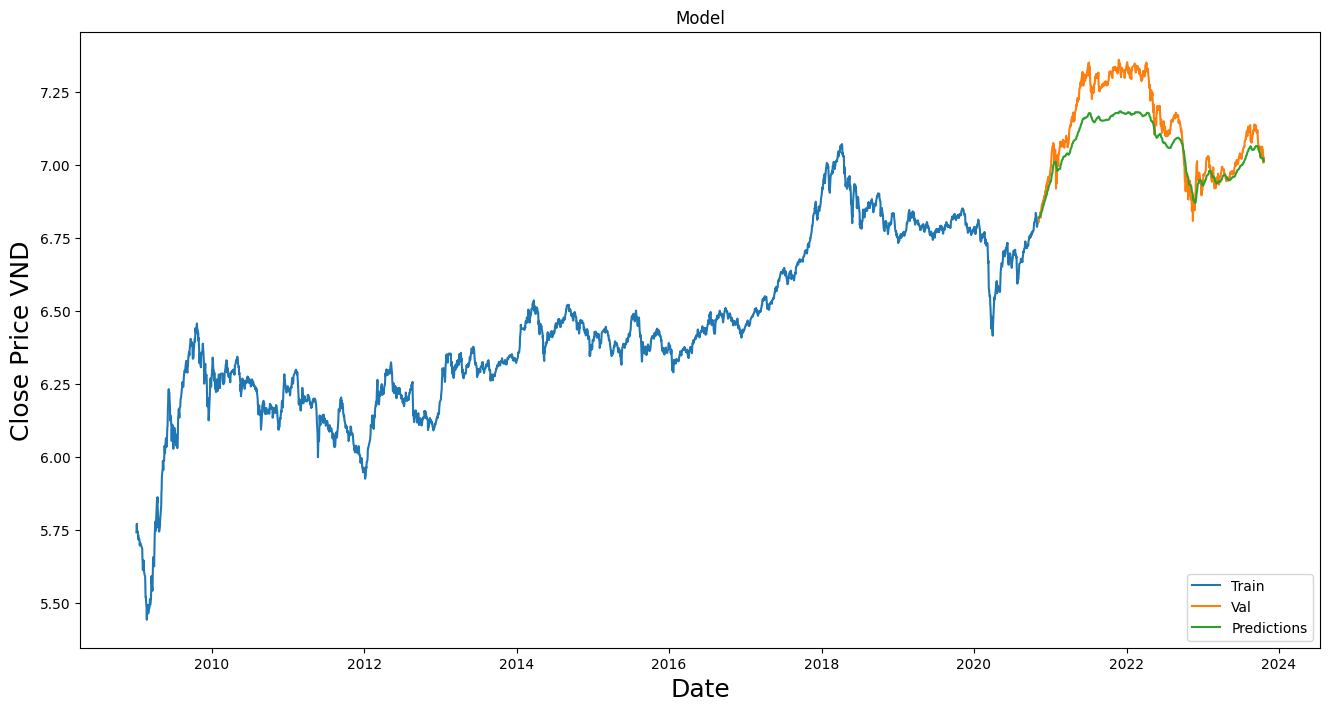

In [ ]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize =(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price VND', fontsize = 18)
plt.plot(train['stationary_Close'])
plt.plot(valid[['stationary_Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,stationary_Close,Predictions
Date,,
2020-11-06,6.805623,6.818798
2020-11-09,6.821565,6.819055
2020-11-10,6.820562,6.820935
2020-11-11,6.820758,6.822681
2020-11-12,6.827629,6.824328
...,...,...
2023-10-16,7.050305,7.022762
2023-10-17,7.039687,7.022047
2023-10-18,7.026036,7.020487


In [ ]:
#Evaluate
from sklearn.metrics import r2_score
r2_score(valid['stationary_Close'],valid['Predictions'])

0.6393418322977846


## Generating Trading Signals
In trading and investment strategies, it's common to set specific thresholds to trigger buy or sell actions based on price changes. This code snippet accomplishes the following:

1. **Buy and Sell Thresholds:**

   - Two threshold values are defined:
     - `buy_threshold`: A positive threshold set to 0.001, indicating that a buy signal will be generated when the price change exceeds this positive value.
     - `sell_threshold`: A negative threshold set to -0.001, indicating that a sell signal will be generated when the price change falls below this negative value.

2. **Function to Generate Trading Signals:**

   - A Python function, `generate_signals`, is created to generate trading signals based on specified thresholds and price changes. The function expects three arguments:
     - `price_changes`: A variable intended to hold price change data.
     - `buy_threshold`: The positive threshold for generating "buy" signals.
     - `sell_threshold`: The negative threshold for generating "sell" signals.

3. **Initializing the `signals` List:**

   - Within the function, an empty list called `signals` is initialized. This list will store the generated trading signals.

4. **Iterating Through Price Changes:**

   - The code uses a loop to iterate through the price change data. The loop starts from index 1 to calculate the price change relative to the previous time period.

5. **Calculating Percentage Price Change:**

   - For each iteration, the percentage price change between consecutive time periods is computed. This is achieved by taking the difference between the current prediction (`valid.Predictions[i]`) and the previous prediction (`valid.Predictions[i - 1]`) and dividing it by the previous prediction. This calculation quantifies the relative price change.

6. **Generating Trading Signals:**

   - The code evaluates whether the calculated price change crosses the defined buy or sell thresholds.
   - If the price change is greater than the `buy_threshold`, the code appends "buy" to the `signals` list, indicating a buying signal.
   - If the price change is less than the `sell_threshold`, "sell" is appended to the `signals` list, signifying a selling signal.
   - If the price change falls within the thresholds (between `-sell_threshold` and `buy_threshold`), the code appends "hold" to the `signals` list, indicating no immediate action.



This code provides a basic framework for generating trading signals based on predefined thresholds and price changes.


In [ ]:
#Using non-Logarithm Close Price
valid['Close_predictions'] = np.exp(valid['Predictions'])
valid

<ipython-input-404-deebf7aaa8e4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,stationary_Close,Predictions,Close_predictions
Date,,,
2020-11-06,6.805623,6.818798,914.884277
2020-11-09,6.821565,6.819055,915.119873
2020-11-10,6.820562,6.820935,916.841614
2020-11-11,6.820758,6.822681,918.444458
2020-11-12,6.827629,6.824328,919.958008
...,...,...,...
2023-10-16,7.050305,7.022762,1121.880859
2023-10-17,7.039687,7.022047,1121.079102
2023-10-18,7.026036,7.020487,1119.331421


In [ ]:
# Define Buy and Sell Thresholds
buy_threshold = 0.005  # Set a positive threshold for buying
sell_threshold = -0.005  # Set a negative threshold for selling# Function to Generate Trading Signals
def generate_signals(price_changes, buy_threshold, sell_threshold):
    # Initialize an empty list to store trading signals.
    signals = []

    # Iterate through the price changes and generate signals.
    for i in range(1, len(valid.Close_predictions)):
        # Calculate the percentage price change between consecutive time periods.
        price_change = (valid.Close_predictions[i] - valid.Close_predictions[i - 1]) / valid.Close_predictions[i - 1]
        # Check if the price change crosses the buy or sell thresholds.
        if price_change > buy_threshold:
            signals.append("buy")
        elif price_change < sell_threshold:
            signals.append("sell")
        else:
            signals.append("hold")

    # Return the list of generated trading signals.
    return signals


In [ ]:
# Generate Trading Signals and Add Them to 'valid' DataFrame
#  Generate Trading Signals
signals = generate_signals(valid.Close_predictions, buy_threshold, sell_threshold)
#  Add the Signals to the 'valid' DataFrame
valid['Signals'] = [' '] + signals

<ipython-input-406-f0dbedc67167>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



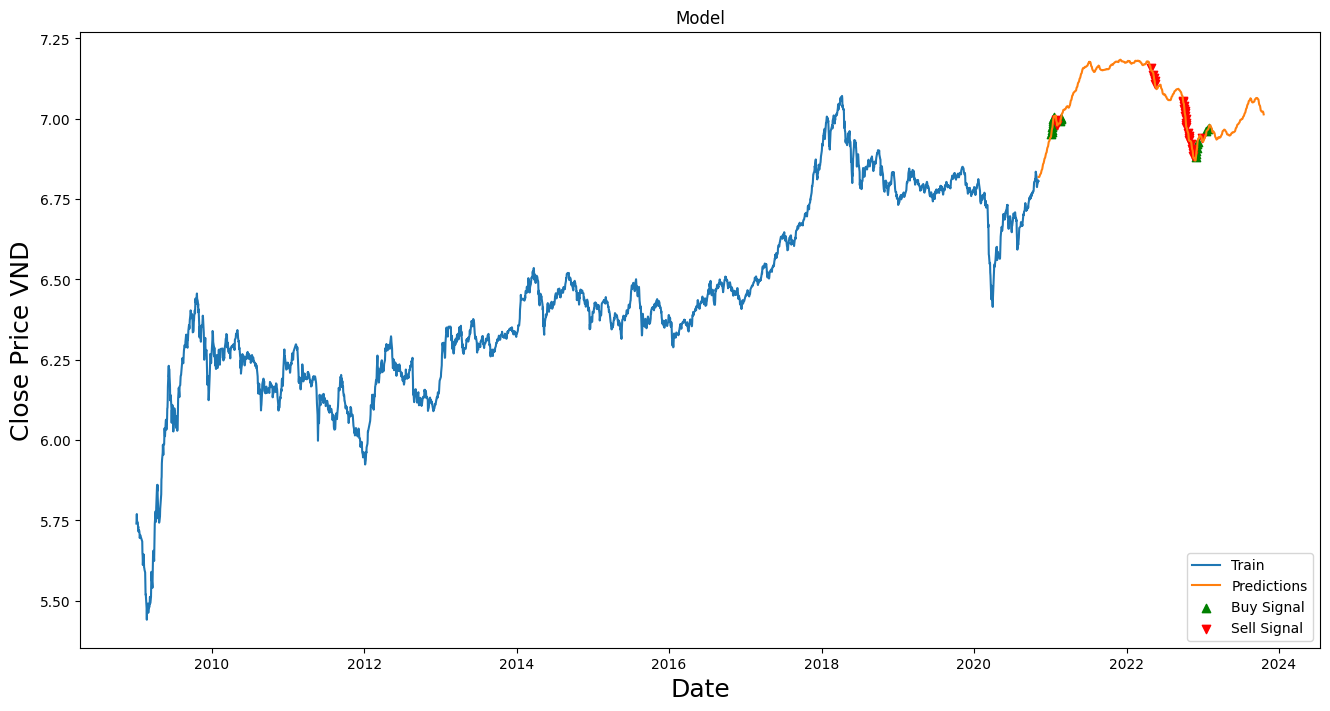

In [ ]:
#Visualize
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price VND', fontsize=18)

# Plot the training data
plt.plot(train['stationary_Close'], label='Train')

# Plot the validation data and model predictions
plt.plot(valid['Predictions'], label='Predictions')

# Add buy Signals as green triangles (^)
plt.scatter(valid[valid['Signals'] == 'buy'].index, valid[valid['Signals'] == 'buy']['Predictions'], marker='^', color='g', label='Buy Signal')

# Add sell Signals as red triangles (v)
plt.scatter(valid[valid['Signals'] == 'sell'].index, valid[valid['Signals'] == 'sell']['Predictions'], marker='v', color='r', label='Sell Signal')

plt.legend(loc='lower right')
plt.show()


## Portfolio Initialization and Backtesting with LSTM

This code backtest a trading strategy based on the buy and sell signals generated from the MACD indicator and calculates various trading statistics. The goal is to assess the performance of the trading strategy over VN-30 data. Here's a detailed breakdown of what the code does:

## 1. Initial Balance Setup

An initial balance of $10,000 is set as the starting capital for the trading simulation.

## 2. Trading Simulation

- Variables like `balance`, `position`, `buy_price`, `total_trades`, and `winning_trades` are initialized to keep track of trading-related information.
- The code iterates through the DataFrame `df1` to simulate trades based on the MACD-based buy and sell signals.
- When a "Buy" signal is generated and the current position is not long (1), a Buy trade is executed. The `buy_price` is set, and the `position` is updated to long (1).
- When a "Sell" signal is generated and the current position is long (1), a Sell trade is executed. The code calculates the trade's profit or loss based on the difference between the selling price and the buying price. Statistics like the total number of trades and winning trades are updated. The `position` is set to short (-1).

## 3. Calculate Final Balance

The code calculates the final balance, considering the last trade if any.

## 4. Calculate Trading Statistics

The following trading statistics are computed:
- Total Return: This is the percentage change in the final balance compared to the initial balance.
- Total Trades: The total number of trades executed.
- Win Rate: The percentage of winning trades among all trades.


These statistics help traders and investors evaluate the effectiveness of the trading strategy and assess its profitability over historical data.

This code is a valuable tool for backtesting and evaluating trading strategies, enabling users to analyze the potential performance of their strategies in real-world scenarios.


In [ ]:
# Define an initial balance for the trading simulation
initial_balance = 10000
# Initialize balance, position, buy_price, and trading statistics
balance = initial_balance
position = 0
buy_price = 0
total_trades = 0
winning_trades = 0

for i in range(len(valid.index)):
    if valid['Signals'][i] == "buy" and position != 1:
       # Execute a Buy trade if the signal is "Buy" and the current position is not long (1)
        buy_price = valid['Close_predictions'][i]
        position = 1
    elif valid['Signals'][i] == "sell" and position != -1:
        if position == 1:
         # Execute a Sell trade if the signal is "Sell" and the current position is long (1)
            balance += (valid['Close_predictions'][i] - buy_price)
            total_trades += 1
            if valid['Close_predictions'][i] > buy_price:
                winning_trades += 1
        position = -1  # Set the position to short (-1)

# Calculate the final balance considering the last trade if any
final_balance = balance + position * (valid['Close_predictions'].iloc[-1] - buy_price)
# Calculate the total return as a percentage
total_return = (final_balance - initial_balance) / initial_balance
# Calculate the win rate as a percentage
win_rate = winning_trades / total_trades if total_trades > 0 else 0

print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")


Initial Balance: 10000
Final Balance: 10352.844360351562
Total Return: 3.53%
Total Trades: 3
Win Rate: 100.00%


Based on the  indications, the trading simulation conducted  2 trades on historical data

The final balance of  10352 shows that the method resulted in a tiny overall return when compared to the original capital of 10,000.

The 3.53%% positive total return demonstrates that the trading method

The win rate of 100.00% indicates that may be low-frequency

# Combining Rule-Based MACD, Bollinger Bands with RSI Strategy

Trading and investment strategies often employ a combination of technical indicators to make informed decisions.  Rule-based strategies, such as those using MACD and Bollinger Bands with RSI, offers a well-rounded approach to trading in financial markets. Here's why this combination can be a potent strategy:

## 1. Diverse Signal Sources

### a. MACD:
   - MACD is a trend-following momentum indicator that helps traders identify changes in the strength and direction of a trend. It generates signals based on the difference between two moving averages.
   - The MACD crossover strategy, for example, can trigger buy and sell signals when the MACD line crosses above or below the signal line, indicating potential trend reversals.

### b. Bollinger Bands:
   - Bollinger Bands provide information about price volatility and potential trend reversal points. They consist of an upper band (indicating overbought conditions), a lower band (indicating oversold conditions), and a middle band (representing the moving average).
   - Traders often use Bollinger Bands to identify overextended price movements and potential reversal opportunities.

### c. RSI (Relative Strength Index):
   - RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought and oversold conditions.
   - RSI-based strategies generate signals when the indicator crosses certain thresholds, signaling potential trend reversals.

## 2. Confirmation and Validation

By combining these indicators, traders can seek confirmation and validation of signals. For example:

   - A MACD crossover signal that aligns with a Bollinger Bands signal or RSI signal can provide stronger evidence of a potential trade opportunity.
   - In case of conflicting signals from these indicators, traders may choose to exercise caution or avoid the trade altogether, reducing the likelihood of false signals.

In summary, combining rule-based strategies involving MACD, Bollinger Bands, and RSI can provide a robust approach to trading and investment. These strategies offer diverse signal sources, the ability to confirm and validate signals


## Analyzing Stock Data with MACD
This cell code is used to analyze stock price data using the MACD (Moving Average Convergence Divergence) indicator and visualize it along with candlestick charts and MACD histograms.

## 1. Calculating MACD and Related Metrics

The `calculate_macd` function calculates various MACD-related metrics for a given dataset:

- **Short EMA:** It calculates the Exponential Moving Average (EMA) with a short window (12 days by default) for the closing prices.
- **Long EMA:** It calculates the EMA with a longer window (26 days by default) for the closing prices.
- **MACD:** The MACD is obtained by subtracting the Long EMA from the Short EMA.
- **Signal Line:** It calculates the Signal Line, which is an EMA of the MACD itself.
- **Histogram:** The MACD Histogram is derived by subtracting the Signal Line from the MACD.

The function returns the original dataset with these calculated metrics added.

## 2. Creating Candlestick Charts and MACD Plot

This code uses Plotly to create a subplot with two rows:

### a. Candlestick Chart
   - The upper row of the subplot displays a candlestick chart. It shows the opening, high, low, and closing prices of the stock, providing a visual representation of price movements.
   - Candlesticks are color-coded to indicate whether the closing price is higher or lower than the opening price.

### b. MACD and Histogram Plot
   - The lower row displays two line plots: one for the MACD and the other for the Signal Line.
   - The MACD line is typically displayed in one color (in this case, orange), while the Signal Line is displayed in another color (black).
   - A histogram is superimposed on the MACD plot, where bars are colored differently depending on whether the MACD is above or below the Signal Line.





In [ ]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['Short_EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['Long_EMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['Short_EMA'] - data['Long_EMA']
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['Histogram'] = data['MACD'] - data['Signal_Line']
    return data

In [ ]:
df_new =  calculate_macd(df_new)

In [ ]:
df_new

,Date,Close,Open,High,Low,Volume,Change,Short_EMA,Long_EMA,MACD,Signal_Line,Histogram
0,2023-10-20,1123.69,1104.83,1125.63,1094.78,154960.0,1.70%,1123.690000,1123.690000,0.000000,0.000000,0.000000
1,2023-10-19,1104.89,1126.67,1126.86,1104.89,166990.0,-1.84%,1120.797692,1122.297407,-1.499715,-0.299943,-1.199772
2,2023-10-18,1125.56,1143.95,1144.89,1108.68,233690.0,-1.36%,1121.530355,1122.539081,-1.008726,-0.441700,-0.567026
3,2023-10-17,1141.03,1157.63,1160.30,1141.03,141760.0,-1.06%,1124.530300,1123.908779,0.621522,-0.229055,0.850577
4,2023-10-16,1153.21,1165.75,1168.02,1151.13,173240.0,-1.15%,1128.942562,1126.079239,2.863322,0.389420,2.473902
...,...,...,...,...,...,...,...,...,...,...,...,...
3688,2009-01-09,312.90,312.90,312.90,312.90,NaN,-0.39%,301.949714,289.876068,12.073646,10.551674,1.521971
3689,2009-01-08,314.14,314.14,314.14,314.14,NaN,-1.99%,303.825143,291.673397,12.151746,10.871689,1.280057
3690,2009-01-07,320.53,320.53,320.53,320.53,NaN,2.01%,306.395121,293.810923,12.584198,11.214190,1.370007
3691,2009-01-06,314.21,314.21,314.21,314.21,NaN,0.96%,307.597410,295.321966,12.275444,11.426441,0.849003


In [ ]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.03)

# Add Candlestick chart
fig = make_subplots(rows=2, cols=1)
# Close Line
fig.append_trace(
    go.Scatter(
        x=df_new['Date'],
        y=df_new['Open'],
        line=dict(color='#ff9900', width=1),
        name='open',
        # showlegend=False,
        legendgroup='1',
    ), row=1, col=1
)
# Candlestick chart for pricing
fig.append_trace(
    go.Candlestick(
        x=df_new['Date'],
        open=df_new['Open'],
        high=df_new['High'],
        low=df_new['Low'],
        close=df_new['Close'],
        increasing_line_color='#ff9900',
        decreasing_line_color='black',
        showlegend=False
    ), row=1, col=1
)
# Fast Signal (%k)
fig.append_trace(
    go.Scatter(
        x=df_new['Date'],
        y=df_new['MACD'],
        line=dict(color='#ff9900', width=2),
        name='macd',
        # showlegend=False,
        legendgroup='2',
    ), row=2, col=1
)
# Slow signal (%d)
fig.append_trace(
    go.Scatter(
        x=df_new['Date'],
        y=df_new['Signal_Line'],
        line=dict(color='#000000', width=2),
        # showlegend=False,
        legendgroup='2',
        name='signal'
    ), row=2, col=1
)
# Colorize the histogram values
colors = np.where(df_new['Histogram'] < 0, '#000', '#ff9900')
# Plot the histogram
fig.append_trace(
    go.Bar(
        x=df_new['Date'],
        y=df_new['Histogram'],
        name='histogram',
        marker_color=colors,
    ), row=2, col=1
)
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)
# Update options and show plot
fig.update_layout(layout)
fig.show()

## Analyzing Stock Data with Bollinger Bands
This cell code is used to analyze stock price data using the Bollinger Bands  indicator and visualize it
## 1. Bollinger Bands Calculation

The `BBANDS` function calculates Bollinger Bands using the following steps:

- **Moving Average (MA):** It computes the simple moving average of the closing prices over a specified number of days (20 days by default).
- **Standard Deviation (SD):** It calculates the standard deviation of the closing prices over the same number of days.
- **Upper Band:** The upper Bollinger Band is obtained by adding two times the standard deviation to the moving average.
- **Middle Band:** The middle Bollinger Band is the calculated moving average.
- **Lower Band:** The lower Bollinger Band is derived by subtracting two times the standard deviation from the moving average.

The calculated Bollinger Bands are added to the dataset.

## 2. Visualizing Bollinger Bands and Candlestick Chart

The code utilizes Plotly to create a financial chart with several components:

- A candlestick chart displays the opening, high, low, and closing prices of the stock.
   - Green candlesticks indicate rising prices (increasing_line_color='green').
   - Red candlesticks represent falling prices (decreasing_line_color='red').

- Upper Bollinger Band, Middle Band, and Lower Bollinger Band lines are plotted as scatter plots on the same chart.
   - The Upper and Lower Bands are shown as dashed lines for clear differentiation.



In [ ]:
#Fuction for Bollinger Bands
def BBANDS(data, days):
    MA = data['Close'].rolling(window=days).mean()
    SD = data['Close'].rolling(window=days).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD)
    data['LowerBand'] = MA - (2 * SD)
    return data

In [ ]:
#Set and use fuction BBands
days = 20
df_new = BBANDS(df_new, days)

In [ ]:
#Visualize
fig = go.Figure()
# Add Candlestick chart
fig.add_trace(go.Candlestick(
    x=df_new['Date'],
    open=df_new['Open'],
    high=df_new['High'],
    low=df_new['Low'],
    close=df_new['Close'],
    name='OHLC',
    increasing_line_color='green',
    decreasing_line_color='red'
))
# Add upper Bollinger Band line as a scatter plot
fig.add_trace(go.Scatter(x=df_new['Date'], y=df_new['UpperBand'], mode='lines', name='Upper Band', line=dict(dash='dash')))
# Add middle Bollinger Band line as a scatter plot
fig.add_trace(go.Scatter(x=df_new['Date'], y=df_new['MiddleBand'], mode='lines', name='Middle Band'))
# Add lower Bollinger Band line as a scatter plot
fig.add_trace(go.Scatter(x=df_new['Date'], y=df_new['LowerBand'], mode='lines', name='Lower Band', line=dict(dash='dash')))
# Customize the layout of the chart
fig.update_layout(
    title='Bollinger Bands Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    showlegend=True
)

fig.show()

## Analyzing Stock Data with RSI


This code calculates the Relative Strength Index (RSI) and visualizes it alongside a price chart of a stock. RSI is a valuable indicator for assessing overbought or oversold conditions in a stock. Here's a detailed breakdown of what the code does:

## 1. RSI Calculation

The `calculate_rsi` function calculates RSI based on the following steps:

- **Price Change:** It computes daily price changes by taking the difference between consecutive closing prices.
- **Average Gain and Average Loss:** The function calculates the average gain and average loss over a specified window (14 days by default).
- **Gain and Loss:** For each daily price change, it separates gains (positive changes) and losses (negative changes).
- **Average Gain and Average Loss:** These are calculated as the rolling mean of gains and losses over the specified window.
- **Relative Strength (RS):** The RS is determined by dividing the Average Gain by the Average Loss.
- **RSI:** The RSI is calculated using the formula 100 - (100 / (1 + RS)).

The calculated RSI is added to the dataset.

## 2. Visualizing RSI

The code utilizes Plotly to create two separate line charts:

### a. Price Chart
   - The first chart displays the stock's closing prices over time.
   - This provides a visual representation of the stock's price movements.

### b. RSI Chart
   - The second chart shows the RSI values over the same time period.
   - RSI values are typically plotted in red.
   - The y-axis is customized to range from 0 to 100, highlighting the typical RSI thresholds.



In [ ]:
#Fuction RSI
def calculate_rsi(data, window=14):
    # Calculate daily price changes
    data['PriceChange'] = data['Close'].diff()

    # Calculate the average gain and average loss
    data['Gain'] = data['PriceChange'].apply(lambda x: x if x > 0 else 0)
    data['Loss'] = data['PriceChange'].apply(lambda x: abs(x) if x < 0 else 0)

    data['AvgGain'] = data['Gain'].rolling(window=window).mean()
    data['AvgLoss'] = data['Loss'].rolling(window=window).mean()

    # Calculate the Relative Strength (RS) and Relative Strength Index (RSI)
    data['RS'] = data['AvgGain'] / data['AvgLoss']
    data['RSI'] = 100 - (100 / (1 + data['RS']))

    return data

In [ ]:
#Apply fuction RSI
rsi_window = 14
df_new =  calculate_rsi(df_new,rsi_window)

In [ ]:
#Visualize RSI
fig_price = go.Figure()

fig_price.add_trace(go.Scatter(x=df_new['Date'], y=df_new['Close'], mode='lines', name='Close Price'))
# Add a line chart for Close Price
fig_price.update_layout(
    title='Price Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    showlegend=True
)

fig_rsi = go.Figure()

# Add a line chart for RSI

fig_rsi.add_trace(go.Scatter(x=df_new['Date'], y=df_new['RSI'], mode='lines', name='RSI', line=dict(color='red')))

# Customize the layout of the RSI Chart
fig_rsi.update_layout(
    title='Relative Strength Index (RSI) Chart',
    xaxis_title='Date',
    yaxis_title='RSI',
    showlegend=True,
    yaxis=dict(range=[0, 100])
)


fig_price.show()

fig_rsi.show()

Set the same period with LSTM backtest

In [ ]:
df1 = df_new[df_new['Date'] >= '2020-11-09']

## Generating Buy and Sell Signals with MACD and Visualization

This code calculates buy and sell signals based on the MACD indicator and visualizes these signals on a price chart. The purpose is to identify potential entry and exit points for trading or investment. Here's a detailed breakdown of what the code does:

## 1. Buy and Sell Signal Generation

The `Buy_sell_signal` function generates buy and sell signals as follows:

- An empty list, `signals`, is initialized to store the signals.
- A `flag` is set to 0 to represent the current position: 0 for no position, 1 for a long (buy) position, and -1 for a short (sell) position.
- For each data point in the DataFrame:
   - A "Buy" signal is generated when the MACD crosses above the Signal Line and no long position is already open.
   - A "Sell" signal is generated when the MACD crosses below the Signal Line and no short position is already open.
   - A "Hold" signal is generated when no buy or sell conditions are met.
- A "Hold" signal is inserted at the beginning to represent the initial position (no position).

The generated signals are returned as a list.


## 2. Visualization of Buy and Sell Signals

The code creates a line plot of the stock's closing prices over time. Buy and sell signals are overlaid on the price chart for visual analysis:
- Buy signals are indicated by green upward-pointing triangles.
- Sell signals are indicated by red downward-pointing triangles.



This code is a valuable tool for traders and investors looking to incorporate MACD-based signals into their trading strategies and visualize these signals on a price chart.


Set signal Generation for MACD indicator

In [ ]:
def Buy_sell_signal(data):
      # Initialize an empty list to store the buy and sell signals
    signals = []
    flag = 0  # 0 for no position, 1 for long (buy), -1 for short (sell)

    for i in range(1, len(data)):
         # Generate a "Buy" signal when MACD crosses above the signal line and no long position is already open
        if data['MACD'][i] > data['Signal_Line'][i] and data['MACD'][i - 1] <= data['Signal_Line'][i - 1] and flag != 1:
            signals.append("Buy")
            flag = 1
          # Generate a "Sell" signal when MACD crosses below the signal line and no short position is already open
        elif data['MACD'][i] < data['Signal_Line'][i] and data['MACD'][i - 1] >= data['Signal_Line'][i - 1] and flag != -1:
            signals.append("Sell")
            flag = -1
         # Generate a "Hold" signal when no buy or sell conditions are met
        else:
            signals.append("Hold")
            flag = 0
    # Insert a "Hold" signal at the beginning to match the initial position (no position)
    signals.insert(0, "Hold")

    return signals


In [ ]:
# Call the Buy_sell_signal function to generate buy and sell signals for your DataFrame 'df1'
a = Buy_sell_signal(df1)
# Add the generated signals as a new column named 'Signal' to your DataFrame 'df1'
df1['Signal '] = a

<ipython-input-421-47c04e0b95b8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



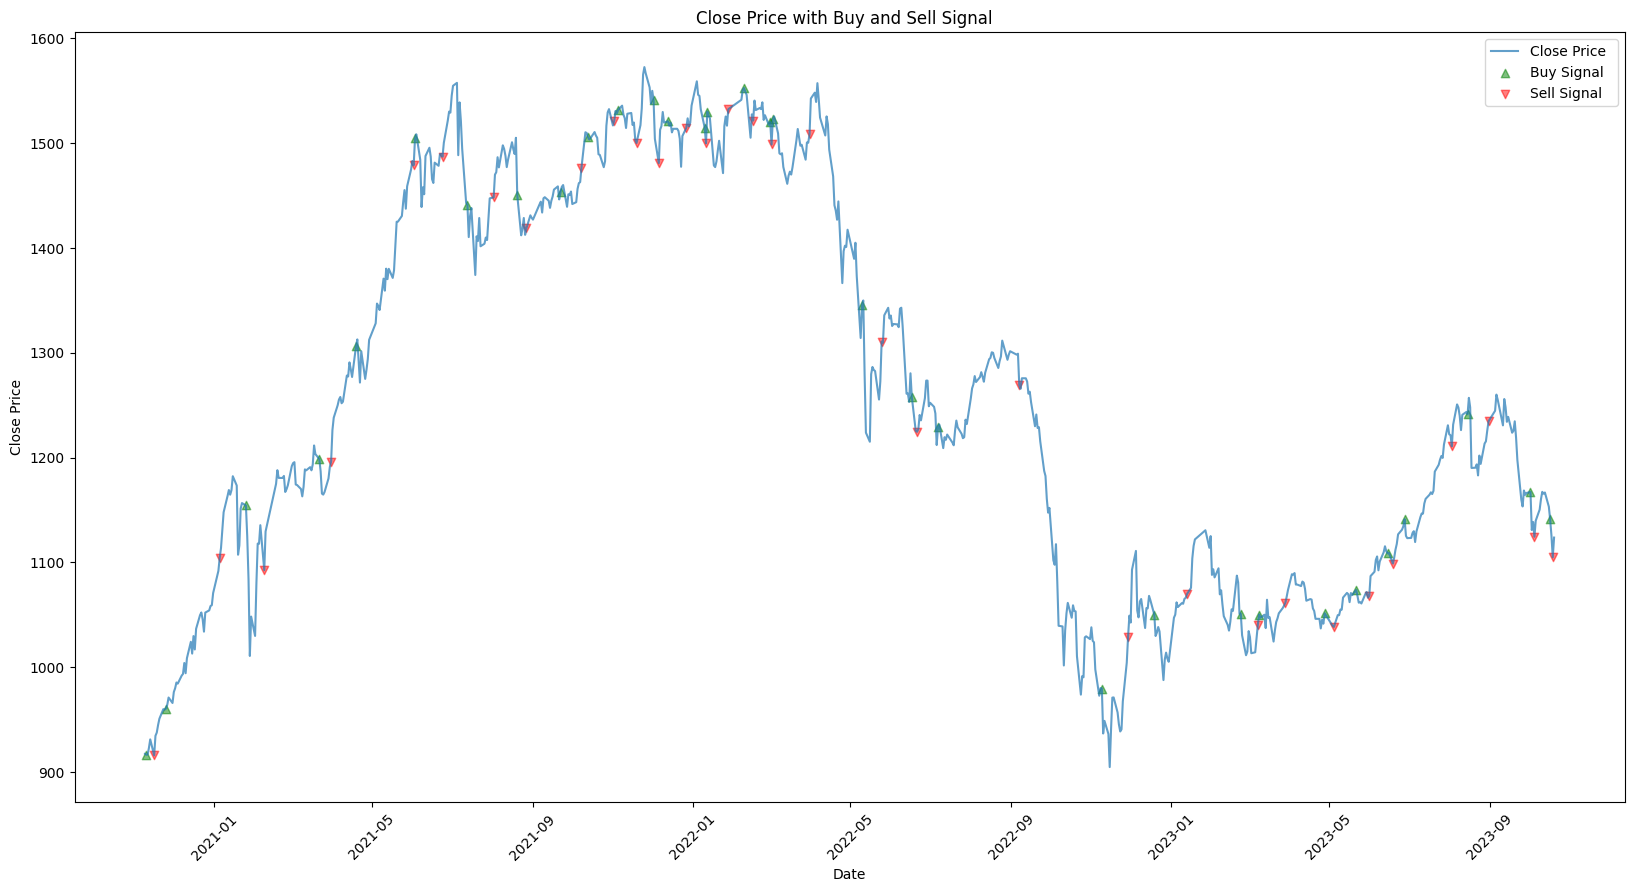

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df1['Date'], df1['Close'], label='Close Price', alpha=0.7)

# Extract Buy signal dates and prices
buy_dates = df1[df1['Signal '] == 'Buy']['Date']
buy_prices = df1[df1['Signal '] == 'Buy']['Close']
plt.scatter(buy_dates, buy_prices, color='green', marker='^', label='Buy Signal  ', alpha=0.5)

# Extract Sell signal dates and prices
sell_dates = df1[df1['Signal '] == 'Sell']['Date']
sell_prices = df1[df1['Signal '] == 'Sell']['Close']
plt.scatter(sell_dates, sell_prices, color='red', marker='v', label='Sell Signal  ', alpha=0.5)

# Set the title, labels, and legend for the plot
plt.title('Close Price with Buy and Sell Signal  ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Generating Buy and Sell Signals with RSI, Close Price, and Bollinger Bands

This code calculates buy and sell signals based on a combination of RSI, Close Price, and Bollinger Bands indicators and visualizes these signals on a price chart. Here's a detailed breakdown of what the code does:

## 1. Buy and Sell Signal Generation

The `Buy_sell_signal1` function generates buy and sell signals as follows:

- An empty list, `signals`, is initialized to store the signals.
- A `flag` is set to 0 to represent the current position: 0 for no position, 1 for a long position.
- For each data point in the DataFrame:
   - An "overbought" condition is checked when the RSI is above 70, indicating a potential overbought situation.
   - An "oversold" condition is checked when the RSI is below 30, indicating a potential oversold situation.
   - A "Buy" signal is generated when the Close Price is above the Upper Bollinger Band, RSI is overbought, and the current position is long.
   - A "Sell" signal is generated when the Close Price is below the Lower Bollinger Band, RSI is oversold, and the current position is no position.
   - A "Hold" signal is generated when no buy or sell conditions are met.

A "Hold" signal is inserted at the beginning to represent the initial position (no position).

The generated signals are returned as a list.



## 2. Visualization of Buy and Sell Signals

The code creates a line plot of the stock's closing prices over time. Buy and sell signals are overlaid on the price chart for visual analysis:
- Buy signals are indicated by green upward-pointing triangles.
- Sell signals are indicated by red downward-pointing triangles.




In [ ]:
# Define a function to generate buy and sell signals based on RSI, Close Price, and Bollinger Bands
def Buy_sell_signal1(data):
    signals = []
    flag = 0

    for i in range(1, len(data)):
        overbought = data['RSI'][i]  > 70  # Check if RSI is above 70 (overbought)
        oversold = data['RSI'][i]  < 30 # Check if RSI is below 30 (oversold)
        if data['Close'][i] > data['UpperBand'][i] and overbought and flag == 1:
          # Generate a "Buy" signal when the Close Price is above the Upper Bollinger Band, RSI is overbought, and the current position is long
            signals.append("Buy")
            flag = 0  # Set the flag to 0 (no position)
        elif data['Close'][i] < data['LowerBand'][i] and  oversold and flag == 0:
           # Generate a "Sell" signal when the Close Price is below the Lower Bollinger Band, RSI is oversold, and the current position is no position
            signals.append("Sell")
            flag = 1 # Set the flag to 1 (short position)
        else:
            signals.append("Hold") # Generate a "Hold" signal when no buy or sell conditions are met

    # Add a "Hold" signal for the first data point
    signals.insert(0, "Hold")

    return signals


In [ ]:
# Call the Buy_sell_signal function to generate buy and sell signals
b = Buy_sell_signal1(df1)
df1['Signal1'] = b

<ipython-input-424-6093e67984f9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



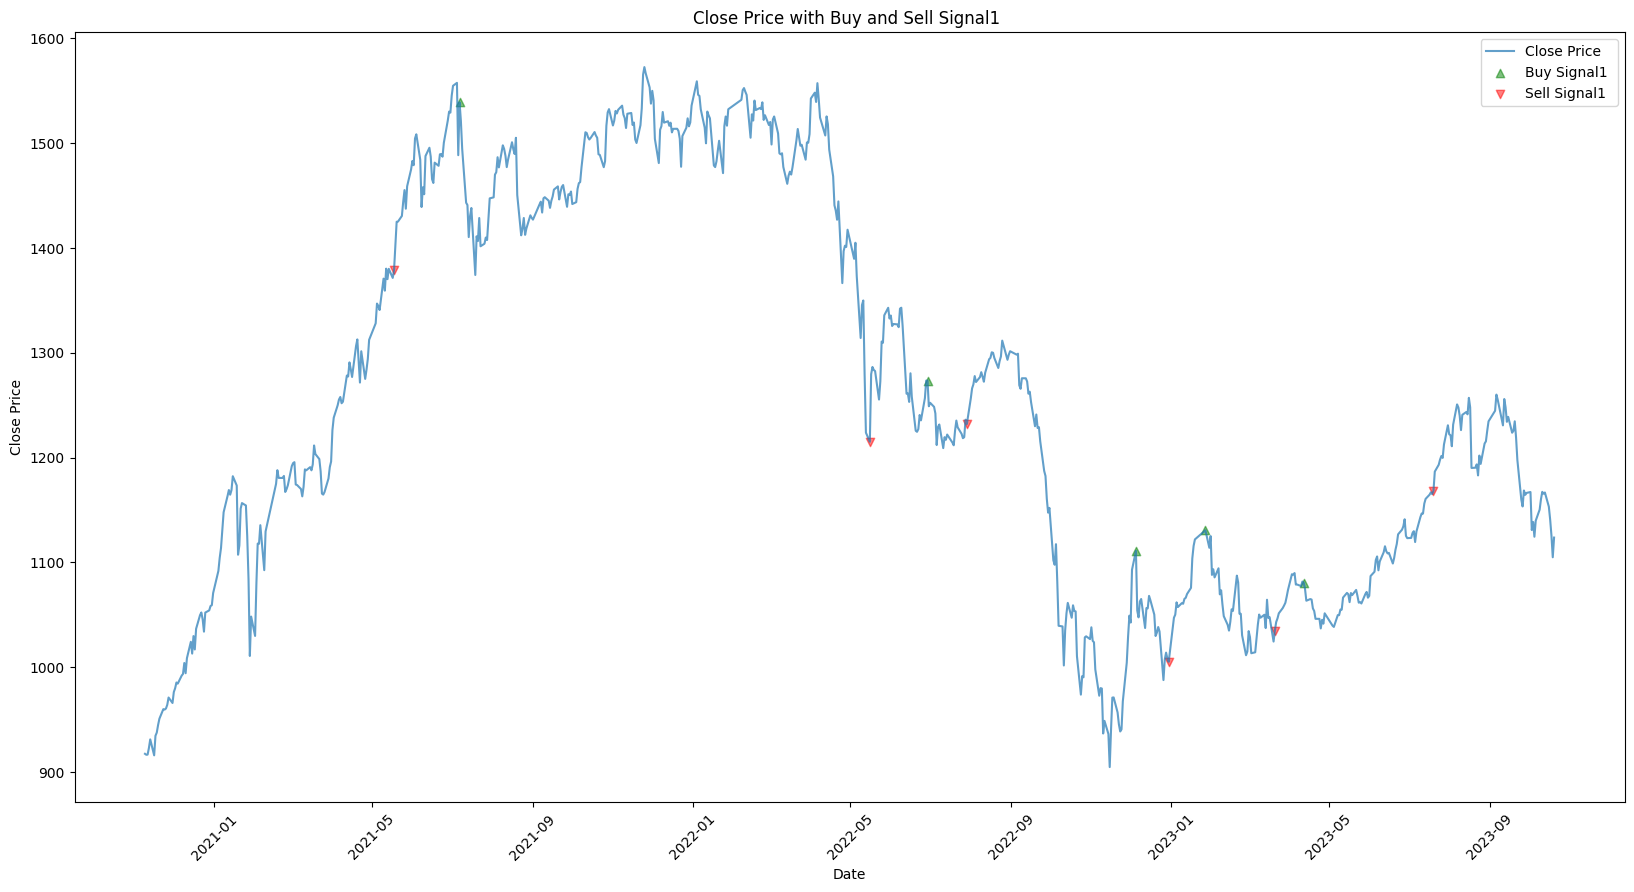

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df1['Date'], df1['Close'], label='Close Price', alpha=0.7)

# Mark Buy Signal1
buy_dates = df1[df1['Signal1'] == 'Buy']['Date']
buy_prices = df1[df1['Signal1'] == 'Buy']['Close']
plt.scatter(buy_dates, buy_prices, color='green', marker='^', label='Buy Signal1 ', alpha=0.5)

# Mark Sell Signal1
sell_dates = df1[df1['Signal1'] == 'Sell']['Date']
sell_prices = df1[df1['Signal1'] == 'Sell']['Close']
plt.scatter(sell_dates, sell_prices, color='red', marker='v', label='Sell Signal1 ', alpha=0.5)

plt.title('Close Price with Buy and Sell Signal1 ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Combining Trading Signals from Multiple Strategies
This code combines trading signals from two different strategies, MACD (Moving Average Convergence Divergence) and Bollinger Bands, and visualizes the combined signals on a price chart. The goal is to increase the total trades. Here's a detailed breakdown of what the code does:

## 1. Signal Generation from MACD and Bollinger Bands

The `Combine_strategies` function generates trading signals from two separate strategies:
- MACD-based signals generated by the `Buy_sell_signal` function.
- Bollinger Bands-based signals generated by the `Buy_sell_signal1` function.

## 2. Combining Signals

The code combines signals from the two strategies as follows:
- If a "Buy" signal is generated by either MACD or Bollinger Bands, a "Buy" signal is assigned.
- If a "Sell" signal is generated by either MACD or Bollinger Bands, a "Sell" signal is assigned.
- If both strategies generate a "Hold" signal, a "Hold" signal is assigned.

The combined signals are stored in the 'signal' column of the DataFrame.

## 3. Visualization of Combined Signals

The code creates a line plot of the stock's closing prices over time. Combined buy and sell signals are overlaid on the price chart for visual analysis:
- Buy signals are indicated by green upward-pointing triangles.
- Sell signals are indicated by red downward-pointing triangles.




In [ ]:
# Define a function to combine trading signals from two different strategies
def Combine_strategies(data):
      # Generate MACD-based trading signals
    macd_signals = Buy_sell_signal(data)
        # Generate Bollinger Bands-based trading signals
    band_signals = Buy_sell_signal1(data)

    combined_signals = []# Initialize a list to store the combined signals

    for i in range(len(data)):
       # Get the MACD and Bollinger Bands signals for the current data point

        macd_signal = macd_signals[i]
        band_signal = band_signals[i]

        # Combine signals from the two strategies

        if ("Buy" in macd_signal and "Hold" in band_signal) or ("Hold" in macd_signal and "Buy" in band_signal) or ("Buy" in macd_signal and "Buy" in band_signal) :
            combined_signals.append("Buy")

        elif ("Sell" in macd_signal and "Hold" in band_signal) or ("Hold" in macd_signal and "Sell" in band_signal)or ("Sell" in macd_signal and "Sell" in band_signal):
            combined_signals.append("Sell")
        else:
            combined_signals.append("Hold")

    return combined_signals




In [ ]:
c = Combine_strategies(df1)
df1['signal'] = c

<ipython-input-427-4bc0d3a79c89>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



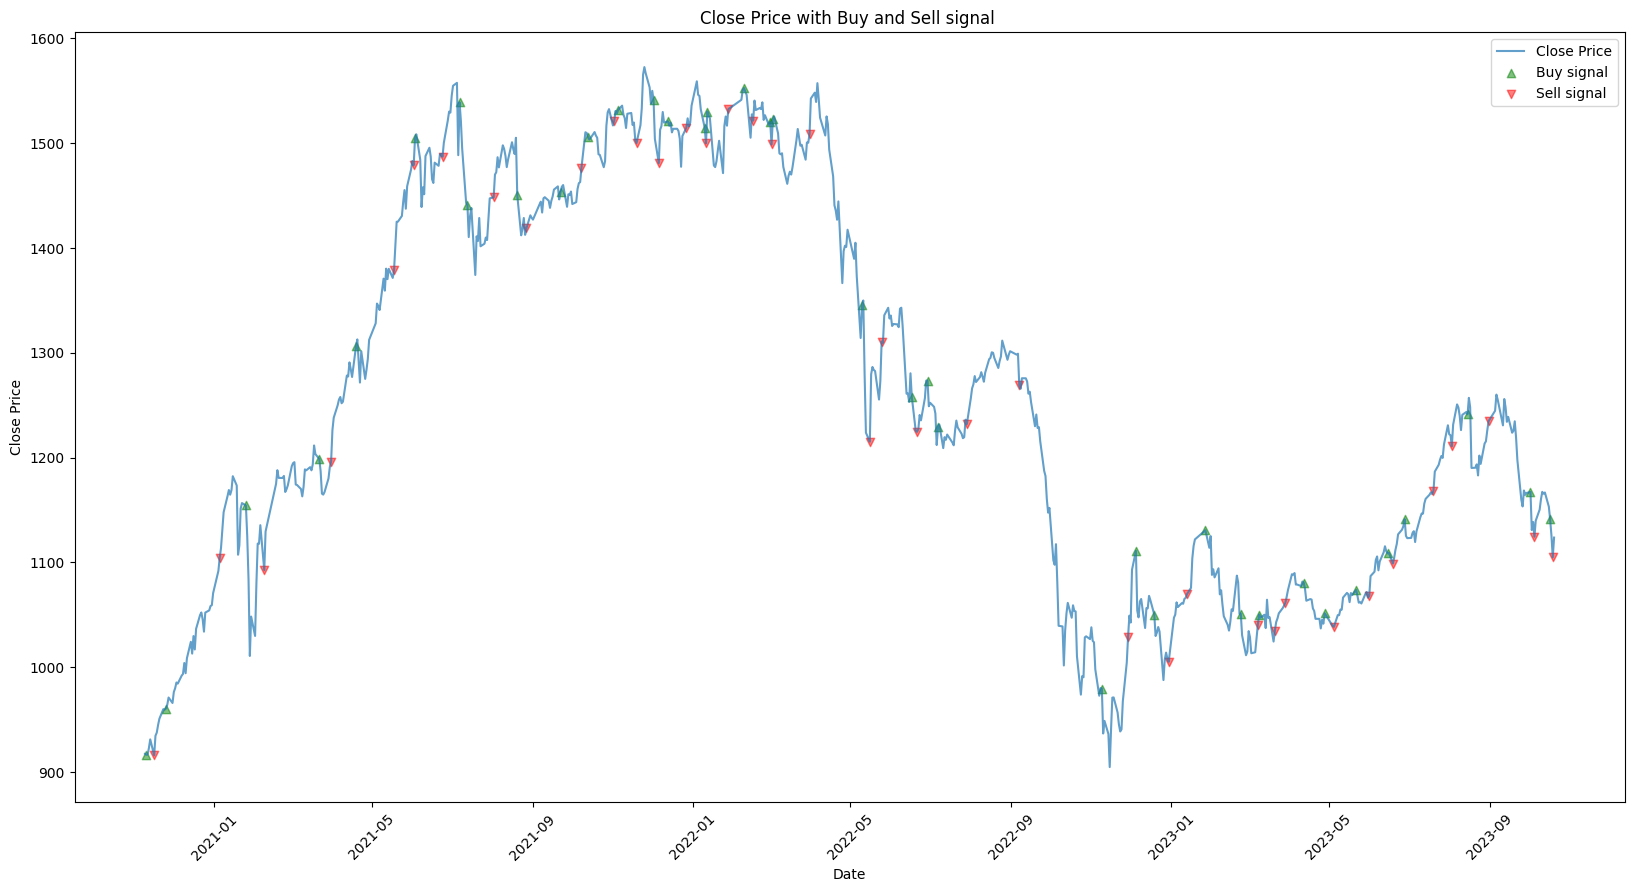

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df1['Date'], df1['Close'], label='Close Price', alpha=0.7)

# Mark Buy signal
buy_dates = df1[df1['signal'] == 'Buy']['Date']
buy_prices = df1[df1['signal'] == 'Buy']['Close']
plt.scatter(buy_dates, buy_prices, color='green', marker='^', label='Buy signal ', alpha=0.5)

# Mark Sell signal
sell_dates = df1[df1['signal'] == 'Sell']['Date']
sell_prices = df1[df1['signal'] == 'Sell']['Close']
plt.scatter(sell_dates, sell_prices, color='red', marker='v', label='Sell signal ', alpha=0.5)

plt.title('Close Price with Buy and Sell signal ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Portfolio Initialization and Backtesting with MACD

This code backtest a trading strategy based on the buy and sell signals generated from the MACD indicator and calculates various trading statistics. The goal is to assess the performance of the trading strategy over VN-30 data. Here's a detailed breakdown of what the code does:

## 1. Initial Balance Setup

An initial balance of $10,000 is set as the starting capital for the trading simulation.

## 2. Trading Simulation

- Variables like `balance`, `position`, `buy_price`, `total_trades`, and `winning_trades` are initialized to keep track of trading-related information.
- The code iterates through the DataFrame `df1` to simulate trades based on the MACD-based buy and sell signals.
- When a "Buy" signal is generated and the current position is not long (1), a Buy trade is executed. The `buy_price` is set, and the `position` is updated to long (1).
- When a "Sell" signal is generated and the current position is long (1), a Sell trade is executed. The code calculates the trade's profit or loss based on the difference between the selling price and the buying price. Statistics like the total number of trades and winning trades are updated. The `position` is set to short (-1).

## 3. Calculate Final Balance

The code calculates the final balance, considering the last trade if any.

## 4. Calculate Trading Statistics

The following trading statistics are computed:
- Total Return: This is the percentage change in the final balance compared to the initial balance.
- Total Trades: The total number of trades executed.
- Win Rate: The percentage of winning trades among all trades.


These statistics help traders and investors evaluate the effectiveness of the trading strategy and assess its profitability over historical data.

This code is a valuable tool for backtesting and evaluating trading strategies, enabling users to analyze the potential performance of their strategies in real-world scenarios.


In [ ]:
# Define an initial balance for the trading simulation

initial_balance = 10000
# Initialize balance, position, buy_price, and trading statistics

balance = initial_balance
position = 0
buy_price = 0
total_trades = 0
winning_trades = 0

for i in range(1, len(df1)):
    if df1['Signal '][i] == "Buy" and position != 1:
        # Execute a Buy trade if the signal is "Buy" and the current position is not long (1)
        buy_price = df1['Close'][i]
        position = 1
    elif df1['Signal '][i] == "Sell" and position != -1:
        if position == 1:
          # Execute a Sell trade if the signal is "Sell" and the current position is long (1)
            balance += (df1['Close'][i] - buy_price)
            total_trades += 1
            if df1['Close'][i] > buy_price:
                winning_trades += 1
        position = -1# Set the position to short (-1)

# Calculate the final balance considering the last trade if any
final_balance = balance + position * (df1['Close'].iloc[-1] - buy_price)
# Calculate the total return as a percentage
total_return = (final_balance - initial_balance) / initial_balance
# Calculate the win rate as a percentage
win_rate = winning_trades / total_trades

# Print the trading simulation results
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")

Initial Balance: 10000
Final Balance: 9881.56
Total Return: -1.18%
Total Trades: 31
Win Rate: 25.81%


Based on the MACD indicator indications, the trading simulation conducted 31 trades on historical data.

The final balance of 9,881.56 shows that the method resulted in a tiny overall loss when compared to the original capital of 10,000.

The -1.18% negative total return demonstrates that the trading method, as implemented in this simulation, did not produce a positive return.

The win rate of 25.81% indicates that about a quarter of the trades were profitable. While this suggests that the strategy had some winning trades, it also had a significant number of losing trades.

## Portfolio Initialization and Backtesting with Bollinger Bands and RSI


In [ ]:
# Define an initial balance for the trading simulation
initial_balance = 10000
# Initialize balance, position, buy_price, and trading statistics
balance = initial_balance
position = 0
buy_price = 0
total_trades = 0
winning_trades = 0

for i in range(1, len(df1)):
    if df1['Signal1'][i] == "Buy" and position != 1:
       # Execute a Buy trade if the signal is "Buy" and the current position is not long (1)
        buy_price = df1['Close'][i]
        position = 1
    elif df1['Signal1'][i] == "Sell" and position != -1:
        if position == 1:
         # Execute a Sell trade if the signal is "Sell" and the current position is long (1)
            balance += (df1['Close'][i] - buy_price)
            total_trades += 1
            if df1['Close'][i] > buy_price:
                winning_trades += 1
        position = -1# Set the position to short (-1)
# Calculate the final balance considering the last trade if any
final_balance = balance + position * (df1['Close'].iloc[-1] - buy_price)
# Calculate the total return as a percentage
total_return = (final_balance - initial_balance) / initial_balance
# Calculate the win rate as a percentage
win_rate = winning_trades / total_trades

print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")

Initial Balance: 10000
Final Balance: 10352.8
Total Return: 3.53%
Total Trades: 5
Win Rate: 20.00%


Based on the Bollinger Bands and RSI indicator indications, the trading simulation conducted 20 trades on historical data.

The final balance of 10352.8 shows that the method resulted in a tiny overall return when compared to the original capital of 10,000.

The 3.53% positive total return demonstrates that the trading method

The win rate of 20.00% indicates that about a quarter of the trades were profitable. While this suggests that the strategy had some winning trades, it also had a significant number of losing trades.

## Portfolio Initialization and Backtesting with Combining Trading Signals from Multiple Strategies


In [ ]:
# Define an initial balance for the trading simulation
initial_balance = 10000
# Initialize balance, position, buy_price, and trading statistics
balance = initial_balance
position = 0
buy_price = 0
total_trades = 0
winning_trades = 0

for i in range(1, len(df1)):
    if df1['signal'][i] == "Buy" and position != 1:
       # Execute a Buy trade if the signal is "Buy" and the current position is not long (1)
        buy_price = df1['Close'][i]
        position = 1
    elif df1['signal'][i] == "Sell" and position != -1:
        if position == 1:
        # Execute a Sell trade if the signal is "Sell" and the current position is long (1)
            balance += (df1['Close'][i] - buy_price)
            total_trades += 1
            if df1['Close'][i] > buy_price:
                winning_trades += 1
        position = -1
# Calculate the final balance considering the last trade if any
final_balance = balance + position * (df1['Close'].iloc[-1] - buy_price)
# Calculate the total return as a percentage
total_return = (final_balance - initial_balance) / initial_balance
# Calculate the win rate as a percentage
win_rate = winning_trades / total_trades

print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")

Initial Balance: 10000
Final Balance: 9881.56
Total Return: -1.18%
Total Trades: 31
Win Rate: 25.81%


Based on the  indications, the trading simulation conducted  31 trades on historical data.

The final balance of  9881.56 shows that the method resulted in a tiny overall return when compared to the original capital of 10,000.

The -1.18%% negative total return demonstrates that the trading method

The win rate of 25.81%% indicates that about a quarter of the trades were profitable. While this suggests that the strategy had some winning trades, it also had a significant number of losing trades.

# "Buy and Hold" Strategy with Rolling Drawdowns

A "Buy and Hold" strategy with rolling drawdowns is a useful tool for evaluating and understanding the performance of an investment or trading strategy. Here's why this approach is useful:

## 1. **Simplicity and Benchmarking:**
  - The "Buy and Hold" strategy serves as a simple and basic benchmark. It entails purchasing an asset or investment and holding it over an extended period of time without actively trading it. You may determine whether your active trading strategy provides value by comparing the performance of more complex methods to a "Buy and Hold" baseline.


## 2. **Rolling Drawdown Analysis:**
   - Rolling drawdowns are used to track the peak-to-trough drops in the value of an investment over time. This analysis shows how an investment or strategy performs in different market conditions, such as bull and bear markets. It help in identifying times of underperformance and the speed with which a strategy rebounds from losses.



## 3. **Realistic Expectations:**
   - "Buy and Hold" sets realistic expectations for investors. It acknowledges that markets have periods of strong growth and significant declines. This perspective helps investors understand that they need to be prepared for both scenarios.

In conclusion, using a "Buy and Hold" strategy with rolling drawdowns is a valuable tool for assessing the effectiveness of more complex investment or trading strategies.


## Analyzing Stock Data with Rolling Drawdowns

In the provided code, we're conducting an analysis of financial time series data to gain insights into rolling drawdown,

## 1. **Rolling Window Size (14 Days):**
   - The code begins by specifying a rolling window size of 14 days,which time frame can capture short to medium-term trends and patterns in the data. It defines a fixed window of data points that slides or "rolls" over the dataset, allowing us to compute specific metrics within this window at each data point.


## 2. **Calculating Rolling Peak:**
   - The 'Rolling Peak' represents the highest closing price observed in the past 14 days (or the specified window size). It's calculated using the `rolling` method, which calculates the maximum value of the 'Close' prices within the rolling window. This metric helps us identify recent price peaks.

## 3. **Calculating Rolling Drawdown:**
   - The 'Rolling Drawdown' is a vital metric for risk assessment. It quantifies the decline in the asset's value from its recent peak. The formula for calculating the drawdown involves two steps:
     - Subtract the 'Close' price at each time point from the corresponding 'Rolling Peak.'
     - Divide this difference by the 'Rolling Peak' value. This division normalizes the decline as a percentage of the peak value.
   - Rolling drawdown is an essential tool for understanding the risk and potential losses associated with an investment. It helps identify drawdown periods when asset values decrease significantly.

## 4. **Visualization:**
   - The code creates a line chart to visualize the calculated metrics over time.
     - The x-axis represents the 'Date,' providing a time-based context for the analysis.
     - The y-axis shows the values of 'Rolling Drawdown,' 'Rolling Peak,' and 'Close' prices.






In [ ]:
#Set dataset in the same period with 2 backtest below
df_new_1 = df_new_1[df_new_1['Date'] >= '2020-11-09']
df_new_1 = df_new_1.sort_values(by='Date', ascending=True)
df_new_1

,Date,Close,Open,High,Low,Volume,Change
736,2020-11-09,917.42,902.91,917.42,902.91,108930.0,1.61%
735,2020-11-10,916.50,917.45,929.66,916.50,137870.0,-0.10%
734,2020-11-11,916.68,916.98,919.95,910.39,114390.0,0.02%
733,2020-11-12,923.00,916.89,923.00,916.21,85350.0,0.69%
732,2020-11-13,931.20,923.04,931.20,923.00,122990.0,0.89%
...,...,...,...,...,...,...,...
4,2023-10-16,1153.21,1165.75,1168.02,1151.13,173240.0,-1.15%
3,2023-10-17,1141.03,1157.63,1160.30,1141.03,141760.0,-1.06%
2,2023-10-18,1125.56,1143.95,1144.89,1108.68,233690.0,-1.36%
1,2023-10-19,1104.89,1126.67,1126.86,1104.89,166990.0,-1.84%


In [ ]:
# Set the rolling window size to 14
rolling_window = 14
# Set the 'Date' column as the index for the DataFrame 'df_new_1'
df_new_1.set_index('Date', inplace=True)
# Calculate the rolling peak by finding the maximum value of 'Close' within the rolling window
df_new_1['Rolling Peak'] = df_new_1['Close'].rolling(rolling_window, min_periods=1).max()
# Calculate the rolling drawdown by subtracting 'Close' from the rolling peak and dividing by the rolling peak
df_new_1['Rolling Drawdown'] = (df_new_1['Rolling Peak'] - df_new_1['Close']) / df_new_1['Rolling Peak']

In [ ]:
df_new_1 = df_new_1.reset_index()

In [ ]:
fig = px.line(df_new_1, x='Date', y=['Rolling Drawdown', 'Rolling Peak','Close'], title='Rolling Drawdown and Closing Prices')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Value')
fig.show()

##  Signal Generation with Rolling Drawdown and Rolling Peak


## 1. Signal Generation Function




We begin by defining a custom function called `generate_signals(data)` designed to analyze the dataset and generate trading signals based on specific conditions:

- **"BUY" Signals:** We look for instances where the rolling drawdown exceeds certain predefined thresholds (0.05, 0.15, and 0.35). When these thresholds are crossed, a "BUY" signal is generated. This suggests that the asset may be experiencing a significant drawdown, indicating a potential buying opportunity.

- **"SELL" Signals:** Additionally, we generate a "SELL" signal when the rolling peak in the dataset is equal to the closing price. This condition could signify a potential exit point from a position.



##2. Visualization

To visualize these signals, we create a chart that plots the closing prices of the asset over time. Within this chart:

- "BUY" signals are marked with green triangles pointing upwards.
- "SELL" signals are marked with red triangles pointing downwards.


 This approach can be particularly useful for those who prefer a data-driven and rule-based approach to trading and investing.


BUY and hold when drawdown reaches 5%, 15% and 35%

SELL when price reach previous peak

In [ ]:
# Define a function to generate signals based on rolling drawdown and rolling peak
def generate_signals(data):
    signals = []# Initialize a list to store the generated signals

    for i, row in data.iterrows():
        drawdown = row['Rolling Drawdown']
        # Generate "BUY" signals based on different drawdown thresholds
        if drawdown >= 0.05:
            signals.append(('BUY', i))
        if drawdown >= 0.15:
            signals.append(('BUY', i))
        if drawdown >= 0.35:
            signals.append(('BUY', i))

        # Generate a "SELL" signal if the rolling peak is equal to the close price
        if row['Rolling Peak'] == row['Close']:
            signals.append(('SELL', i))

    data['signal'] = None

    for signal, index in signals:
        data.at[index, 'signal'] = signal

    return data

In [ ]:
generate_signals(df_new_1)
df_new_1

,Date,Close,Open,High,Low,Volume,Change,Rolling Peak,Rolling Drawdown,signal
0,2020-11-09,917.42,902.91,917.42,902.91,108930.0,1.61%,917.42,0.000000,SELL
1,2020-11-10,916.50,917.45,929.66,916.50,137870.0,-0.10%,917.42,0.001003,None
2,2020-11-11,916.68,916.98,919.95,910.39,114390.0,0.02%,917.42,0.000807,None
3,2020-11-12,923.00,916.89,923.00,916.21,85350.0,0.69%,923.00,0.000000,SELL
4,2020-11-13,931.20,923.04,931.20,923.00,122990.0,0.89%,931.20,0.000000,SELL
...,...,...,...,...,...,...,...,...,...,...
732,2023-10-16,1153.21,1165.75,1168.02,1151.13,173240.0,-1.15%,1168.60,0.013170,None
733,2023-10-17,1141.03,1157.63,1160.30,1141.03,141760.0,-1.06%,1167.29,0.022497,None
734,2023-10-18,1125.56,1143.95,1144.89,1108.68,233690.0,-1.36%,1167.29,0.035749,None
735,2023-10-19,1104.89,1126.67,1126.86,1104.89,166990.0,-1.84%,1167.29,0.053457,BUY


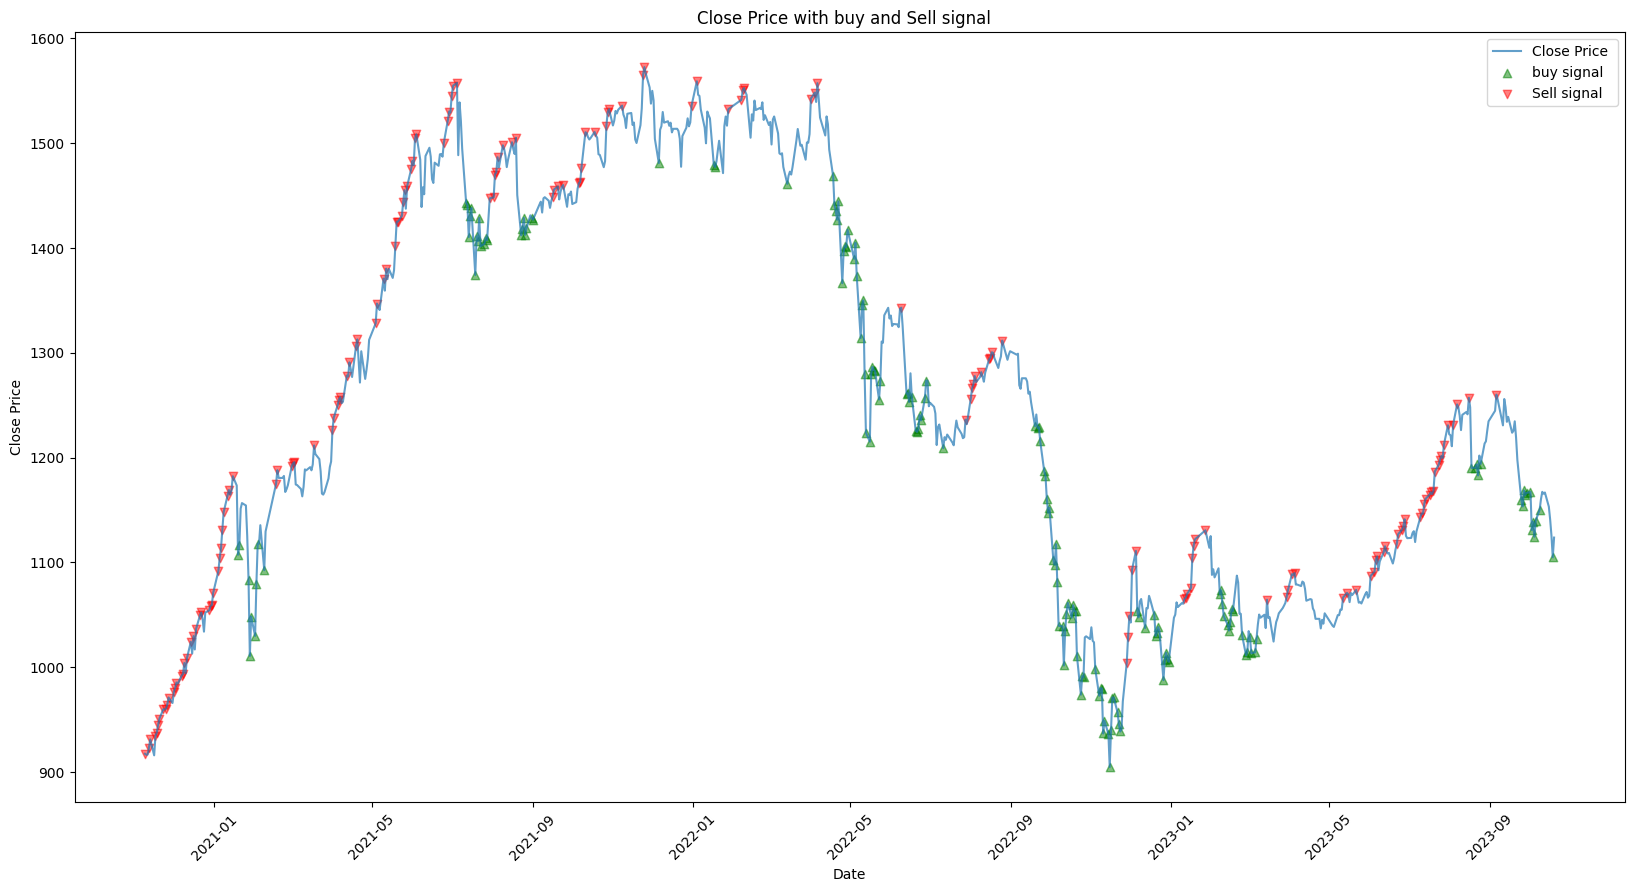

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df_new_1['Date'], df_new_1['Close'], label='Close Price', alpha=0.7)

buy_dates = df_new_1[df_new_1['signal'] == 'BUY']['Date']
buy_prices = df_new_1[df_new_1['signal'] == 'BUY']['Close']
plt.scatter(buy_dates, buy_prices, color='green', marker='^', label='buy signal  ', alpha=0.5)

sell_dates = df_new_1[df_new_1['signal'] == 'SELL']['Date']
sell_prices = df_new_1[df_new_1['signal'] == 'SELL']['Close']
plt.scatter(sell_dates, sell_prices, color='red', marker='v', label='Sell signal  ', alpha=0.5)

plt.title('Close Price with buy and Sell signal  ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Portfolio Initialization and Backtesting with 'Buy and Hold' Strategy


In [ ]:
# Define an initial balance for the trading simulation
initial_balance = 10000
# Initialize balance, position, buy_price, and trading statistics

balance = initial_balance
position = 0
buy_price = 0
total_trades = 0
winning_trades = 0

for i in range(1, len(df_new_1)):
    if df_new_1['signal'][i] == "BUY" and position != 1:
              # Execute a Buy trade if the signal is "Buy" and the current position is not long (1)
        buy_price = df_new_1['Close'][i]
        position = 1
    elif df_new_1['signal'][i] == "SELL" and position != -1:
                # Execute a Sell trade if the signal is "Sell" and the current position is long (1)
        if position == 1:
            balance += (df_new_1['Close'][i] - buy_price)
            total_trades += 1
            if df_new_1['Close'][i] > buy_price:
                winning_trades += 1
        position = -1
# Calculate the final balance considering the last trade if any
final_balance = balance + position * (df_new_1['Close'].iloc[-1] - buy_price)
# Calculate the total return as a percentage
total_return = (final_balance - initial_balance) / initial_balance
# Calculate the win rate as a percentage
win_rate = winning_trades / total_trades

print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")

Initial Balance: 10000
Final Balance: 9962.630000000005
Total Return: -0.37%
Total Trades: 12
Win Rate: 66.67%


We had a relatively high win rate of about 66.67%, indicating that most of your trades were profitable, but the losses from the losing trades slightly outweighed the gains from the winning trades, resulting in a negative total return.




# **Conclusion**
Backtesting using LSTM shows the most favorable overall performance, but it is associated with a lower trading frequency. This is because LSTM tends to make fewer trades. On the other hand, the 'Buy and hold' and Rule-based strategies exhibit the opposite characteristics. They result in lower returns and involve a higher frequency of trades.
